# Quickdraw Doodle
## Test

In [1]:
image_size = 96
batch_size = 256
model_path = 'models/resnetv2.json'
weights_path = 'models/resnetv2.h5'

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lib.preprocessing import json_to_array, image_generator
from lib.data import read_dataset_file, read_dataset_folder, get_classes, get_label_encoder_y

### Import test set

In [3]:
dataset = read_dataset_folder('test_simplified/set_1/', number_of_items=200)
dataset['drawing'] = dataset['drawing'].apply(json_to_array)
len(dataset)

68000

In [4]:
test_generator = image_generator(dataset, include_y=False)

In [5]:
y = dataset['word'].values
from sklearn.preprocessing import OneHotEncoder
labelEncoder_y = get_label_encoder_y()
y = labelEncoder_y.transform(y).reshape(-1, 1)
oneHotEncoder = OneHotEncoder(categorical_features=[0])
y = oneHotEncoder.fit_transform(y).toarray()

### Load model

In [6]:
model_file = open(model_path)
model_json = model_file.read()
model_file.close()

In [ ]:
%%time
from keras.models import model_from_json
classifier = model_from_json(model_json)
classifier.load_weights(weights_path)

### Prediction

In [9]:
from sklearn.metrics import confusion_matrix
import itertools

In [10]:
y_pred = classifier.predict_generator(test_generator, steps=int(math.ceil(len(dataset)/batch_size)), verbose=1)
cm = confusion_matrix(y_pred.argmax(axis=1), y.argmax(axis=1))

266/266 [==============================] - 123s 463ms/step


In [11]:
%%time
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure(figsize=(140,105))
plot_confusion_matrix(cm, classes=get_classes(), title='Confusion matrix')
plt.show()

CPU times: user 5min 17s, sys: 13.8 s, total: 5min 30s
Wall time: 5min 28s


In [12]:
# accuracy
np.sum(np.trace(cm)) / np.sum(cm)

0.7745882352941177

In [13]:
y_arg = y.argmax(axis=1)
predictions = np.argsort(y_pred, axis=1)[:, -3:][:, ::-1]
number_of_correct_predictions = 0
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        if y_arg[i] == predictions[i][j]:
            number_of_correct_predictions += 1/(j+1)
number_of_correct_predictions / len(predictions)

0.8433014705882655

### Submission

In [4]:
%%time
dataset = read_dataset_file('question_simplified.csv', shuffle=False)
dataset['drawing'] = dataset['drawing'].apply(json_to_array)
test_generator = image_generator(dataset)
print(len(dataset))

112199
CPU times: user 4.8 s, sys: 296 ms, total: 5.1 s
Wall time: 5.15 s


In [ ]:
y_sub = classifier.predict_generator(test_generator, steps=int(math.ceil(len(dataset)/batch_size)), verbose=1)

192/439 [============>.................] - ETA: 2:18

In [11]:
y_max = np.argsort(y_sub, axis=1)[:, -3:]
y_max = y_max[:, ::-1]

In [ ]:
labelEncoder_y = get_label_encoder_y()
y_max = labelEncoder_y.inverse_transform(y_max)

In [13]:
y_max

array([['radio', 'stereo', 'snorkel'],
       ['hockey puck', 'bottlecap', 'belt'],
       ['The Great Wall of China', 'castle', 'toe'],
       ...,
       ['rain', 'sheep', 'bush'],
       ['brain', 'bush', 'pond'],
       ['chair', 'toilet', 'laptop']], dtype=object)

In [14]:
labels = []
for i in y_max:
    labels.append(' '.join([e.replace(' ', '_') for e in i]))
y_max = np.array([labels])

In [15]:
result = pd.DataFrame.from_dict({'key_id': dataset['key_id'].values, 'word': labels})
result.to_csv('submission.csv', index=False)

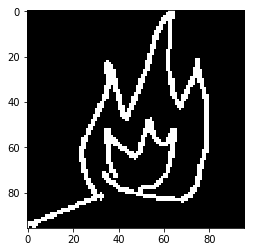

'campfire fireplace rabbit'

In [17]:
image_number = 4
plt.imshow(vector_to_pixel(dataset['drawing'].iloc[image_number], image_size=image_size), cmap='gray')
plt.show()
y_max[0, image_number]